In [127]:
import pandas as pd

In [128]:
path='C:\\Users\dmckenzie\OneDrive - DLR Group\Desktop\Doctored Room And Labels 2.csv'

In [129]:
DATIS=pd.read_csv(path)

In [130]:
DATIS

,UniqueId,Name,OccupancyType,Area,Perimeter,WEBenchmarkingDept
0,'-1028317551:3164766,WORKROOM,NaN,552.076416,96.020833,Amenity
1,'-1274529740:3684468,CAFE / GATHERING,B,972.589695,147.986971,Amenity
2,1274885439:4630147,MOTHER'S,B,182.863241,73.362111,Amenity
3,1274885439:4722876,MOTHER'S,B,376.254259,133.750000,Amenity
4,1274885439:5410216,LIBRARY,A3,450.132802,91.591851,Amenity
...,...,...,...,...,...,...
1508,78,Mail Room,NaN,NaN,NaN,SUPPORT
1509,79,Print Room,NaN,NaN,NaN,SUPPORT
1510,80,Support Space,NaN,NaN,NaN,SUPPORT
1511,81,AV Closet,NaN,NaN,NaN,SUPPORT


<AxesSubplot:>

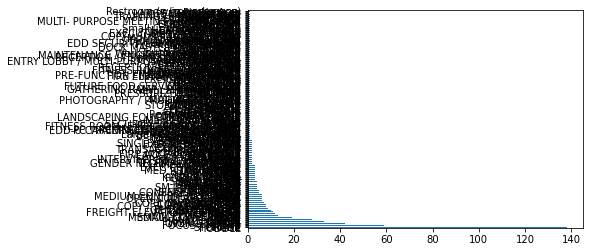

In [131]:
DATIS['Name'].value_counts().plot(kind='barh')

In [132]:
import re
def preprocessor(text): 
    text = re.sub(r'[^\w\s]','', text)
    text = text.lower()
    return text

In [133]:
DATIS['Name'].apply(preprocessor)

0              workroom
1       cafe  gathering
2               mothers
3               mothers
4               library
             ...       
1508          mail room
1509         print room
1510      support space
1511          av closet
1512        supply room
Name: Name, Length: 1513, dtype: object

In [134]:
DATIS['CleanName']=DATIS['Name'].str.replace('/',' ').replace({' +':' '},regex=True).apply(preprocessor)

In [135]:
DATIS['CleanName']

0             workroom
1       cafe gathering
2              mothers
3              mothers
4              library
             ...      
1508         mail room
1509        print room
1510     support space
1511         av closet
1512       supply room
Name: CleanName, Length: 1513, dtype: object

In [136]:
len(DATIS['Name'].value_counts())-len(DATIS['CleanName'].value_counts())

6

In [137]:
DATIS['NameLen']=DATIS['Name'].str.len()
DATIS['Name']=DATIS['Name'].str.lower()
DATIS['TokenCount']=((DATIS['Name'].str.len()-DATIS['Name'].str.replace(' ','').str.len())+1)
DATIS['SpaceRatio']=(DATIS['Area']/DATIS['Perimeter'])

<AxesSubplot:>

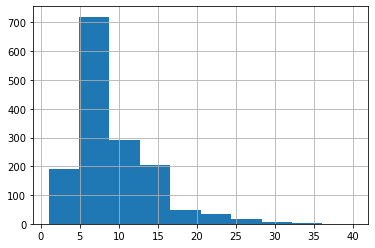

In [138]:
DATIS['NameLen'].hist()

<AxesSubplot:>

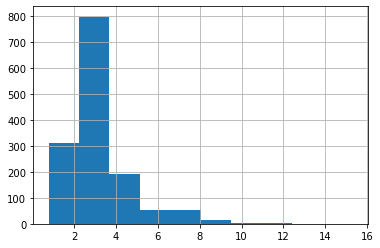

In [139]:
DATIS['SpaceRatio'].hist()

In [140]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pickle

In [141]:
import pandas as pd
import numpy as np
from numpy import random
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt


In [142]:
DATIS.WEBenchmarkingDept=DATIS.WEBenchmarkingDept.str.lower()

In [143]:
import numpy as np

In [144]:
DATIS['WEBenchmarkingDept']=np.where(DATIS['WEBenchmarkingDept']=='services1','services 1', DATIS['WEBenchmarkingDept'])

In [145]:
DATIS.drop_duplicates(['WEBenchmarkingDept','CleanName']).groupby(['WEBenchmarkingDept'])['WEBenchmarkingDept'].count()

WEBenchmarkingDept
amenity                      53
circulation                  45
collaboration: closed        58
collaboration: open          30
desking: open workstation    13
desking: private office      41
lab                          14
services 1                   40
services 2                    4
support                      69
Name: WEBenchmarkingDept, dtype: int64

In [146]:
DATIS['WEBenchmarkingDept']=DATIS['WEBenchmarkingDept'].str.capitalize()

In [147]:
DATIS['WEBenchmarkingDept']=np.where(DATIS['WEBenchmarkingDept']=='Collaboration: closed','Collaboration: Closed', DATIS['WEBenchmarkingDept'])

In [148]:
DATIS['WEBenchmarkingDept']=np.where(DATIS['WEBenchmarkingDept']=='Collaboration: open','Collaboration: Open', DATIS['WEBenchmarkingDept'])

In [159]:
y = DATIS.WEBenchmarkingDept

In [160]:
X = DATIS['CleanName']

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

In [162]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [163]:

#finding

from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer


parameters = {
    #'tfidf__ngram_range': ((1, 1), (1, 2),(1, 3),(1,4)), 
    'tfidf__max_df': (0.25,.4 ,0.5,.6,0.75, 1.0),
    'tfidf__use_idf': (True, False),
    'tfidf__sublinear_tf': (True, False),
    'tfidf__smooth_idf' : (True, False),
    'tfidf__min_df' : (1, 2,3),
    'tfidf__norm': ('l1', 'l2'),
    #'clf__alpha': (0.00001, 0.000001,0.0001,0.001,0.01)
    #'clf__loss': ('log', 'perceptron'),
    #'clf__loss': ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'),
    #'clf__penalty': ('l2', 'elasticnet','l1')
}


pipeline = Pipeline([
               ('tfidf', TfidfVectorizer()),
               ('clf', SGDClassifier(loss='log',penalty='l1')),
              ])

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1)
grid_search.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = grid_search.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.8047493403693932
                           precision    recall  f1-score   support

                  Amenity       0.69      0.69      0.69        13
              Circulation       0.55      0.64      0.59        42
    Collaboration: Closed       0.91      0.92      0.91       111
      Collaboration: Open       0.83      0.56      0.67        18
Desking: open workstation       0.96      0.96      0.96        23
  Desking: private office       0.88      0.80      0.84        85
                      Lab       1.00      1.00      1.00         2
               Services 1       0.89      0.69      0.77        35
               Services 2       0.50      0.50      0.50         2
                  Support       0.65      0.83      0.73        48

                 accuracy                           0.80       379
                macro avg       0.79      0.76      0.77       379
             weighted avg       0.82      0.80      0.81       379



In [164]:
grid_search.best_params_

{'tfidf__max_df': 0.25,
 'tfidf__min_df': 1,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': False,
 'tfidf__sublinear_tf': False,
 'tfidf__use_idf': True}

In [165]:
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer


tfidfvec=TfidfVectorizer(ngram_range=(1,3),max_df=.25,min_df=1,norm='l2',smooth_idf=True,sublinear_tf=False,use_idf=True)
mod=SGDClassifier(penalty='l1',loss='log',alpha=0.00001)

#vectorizer.fit(X_train)
#X_train2=vectorizer.transform(X_train)
#X_test2=vectorizer.transform(X_test)




text_clf = Pipeline([ 
    ('tfidf', tfidfvec),
    ('clf', mod),
])


text_clf.fit(X_train, y_train)

#mod.fit(X_train2, y_train)

from sklearn.metrics import classification_report
#y_pred = mod.predict(X_test2)
y_pred2 = text_clf.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred2, y_test))
print(classification_report(y_test, y_pred2))


#print('accuracy %s' % accuracy_score(y_pred, y_test))
#print(classification_report(y_test, y_pred))

accuracy 0.8153034300791556
                           precision    recall  f1-score   support

                  Amenity       0.61      0.85      0.71        13
              Circulation       0.56      0.67      0.61        42
    Collaboration: Closed       0.87      0.92      0.89       111
      Collaboration: Open       0.89      0.44      0.59        18
Desking: open workstation       0.96      0.96      0.96        23
  Desking: private office       0.96      0.80      0.87        85
                      Lab       1.00      1.00      1.00         2
               Services 1       0.72      0.83      0.77        35
               Services 2       0.50      0.50      0.50         2
                  Support       0.81      0.79      0.80        48

                 accuracy                           0.82       379
                macro avg       0.79      0.78      0.77       379
             weighted avg       0.83      0.82      0.82       379



In [166]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import StringTensorType
from onnxmltools import save_model
from onnxruntime import InferenceSession

In [167]:
onnx_model = convert_sklearn(text_clf,
name='DocClassifierCV-Tfidf-LSVC',
initial_types=[('input', StringTensorType([1, 1]))]
)

save_model(onnx_model, 'cv.onnx')
sess = InferenceSession("cv.onnx")
label_name = sess.get_outputs()[0].name
input_name = sess.get_inputs()[0].name

res = sess.run(None, input_feed={'input': np.array([['1']])})

C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\skl2onnx\operator_converters\text_vectoriser.py:185: UserWarning: Converter for TfidfVectorizer will use scikit-learn regular expression by default in version 1.6.
  UserWarning)
C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\skl2onnx\common\_container.py:595: UserWarning: Unable to find operator 'Tokenizer' in domain 'com.microsoft' in ONNX, op_version is forced to 1.
  op_type, domain))


In [168]:
res

[array(['Services 1'], dtype=object),
 [{'Amenity': 0.135780468583107,
   'Circulation': 0.07175599038600922,
   'Collaboration: Closed': 0.08311403542757034,
   'Collaboration: Open': 0.05778888240456581,
   'Desking: open workstation': 0.03619064390659332,
   'Desking: private office': 0.04738190397620201,
   'Lab': 0.05930555984377861,
   'Services 1': 0.32544636726379395,
   'Services 2': 0.056434303522109985,
   'Support': 0.12680183351039886}]]

In [169]:
with open("TextClassifier1.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [170]:
res

[array(['Services 1'], dtype=object),
 [{'Amenity': 0.135780468583107,
   'Circulation': 0.07175599038600922,
   'Collaboration: Closed': 0.08311403542757034,
   'Collaboration: Open': 0.05778888240456581,
   'Desking: open workstation': 0.03619064390659332,
   'Desking: private office': 0.04738190397620201,
   'Lab': 0.05930555984377861,
   'Services 1': 0.32544636726379395,
   'Services 2': 0.056434303522109985,
   'Support': 0.12680183351039886}]]

In [336]:
import pickle

In [337]:
pickle.dump(vectorizer, open('C:\\Users\dmckenzie\documents\\roomvectorizer.pickle', "wb"))

In [338]:
pickle.dump(mod, open('C:\\Users\dmckenzie\documents\\roommodel.pickle', "wb"))

In [171]:
matchdf=pd.DataFrame({'A':list(y_pred[X_test.isin(list(X_train))==False]),
              'B':list(y_test[X_test.isin(list(X_train))==False])})

In [172]:
matchdf['C']=(matchdf['A']==matchdf['B'])*1

In [173]:
matchdf['D']=1

In [174]:
labels=list(matchdf.groupby(['A'])['D'].sum().index)

In [175]:
scores=list(matchdf.groupby(['A'])['C'].sum().values/matchdf.groupby(['A'])['D'].sum().values)

In [176]:
print('Accuracy:',matchdf['C'].sum()/matchdf['D'].sum())

Accuracy: 0.5102040816326531


In [177]:
pd.DataFrame({'Category':labels,'Guesses':list(matchdf.groupby(['A'])['D'].sum().values),'True Positive Rate':scores})

,Category,Guesses,True Positive Rate
0,Amenity,5,0.400000
1,Collaboration: Closed,10,0.900000
2,Desking: private office,9,0.222222
3,Lab,2,1.000000
4,Services 1,4,1.000000
5,Services 2,1,0.000000
6,Support,18,0.333333


In [40]:
X_train2

NameError: name 'X_train2' is not defined

<AxesSubplot:title={'center':'Classifier Validation Score As Training Data Grows'}, xlabel='Training Data Size', ylabel='Validation Score'>

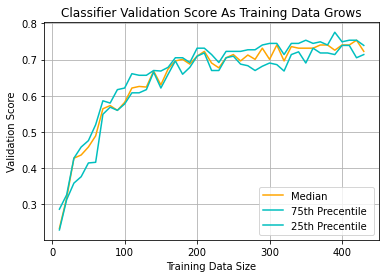

In [64]:
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.datasets import load_iris
from sklearn.linear_model import Ridge

#np.random.seed(0)
#X, y = load_iris(return_X_y=True)
#indices = np.arange(y.shape[0])
#np.random.shuffle(indices)
#X, y = X[indices], y[indices]

train_sizes, train_scores, valid_scores = learning_curve(text_clf,
                                                         X_train, y_train, train_sizes=[10,20,30,40,50,60,70,80,90,100,
                                                                                         110,120,130,140,150,160,170,180,190,200,
                                                                                         210,220,230,240,250,260,270,280,290,300,
                                                                                         310,320,330,340,350,360,370,380,390,400,
                                                                                        410,420,430],cv=5)
pd.DataFrame({'Median':list(pd.DataFrame(valid_scores.transpose()).median()),
             '75th Precentile ':list(pd.DataFrame(valid_scores.transpose()).quantile(0.75)),
             '25th Precentile':list(pd.DataFrame(valid_scores.transpose()).quantile(0.25))},
             index=train_sizes).plot(color = ['orange', 'c','c'],
                                    xlabel='Training Data Size',ylabel='Validation Score',
                                     grid=True,title='Classifier Validation Score As Training Data Grows')

<AxesSubplot:>

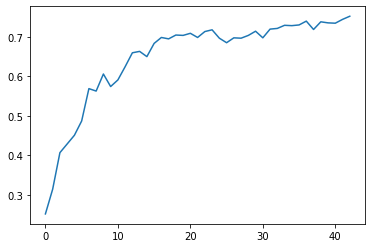

In [61]:
pd.DataFrame(valid_scores.transpose()).mean().plot()

In [43]:
pd.DataFrame(pd.DataFrame(valid_scores.transpose())).plot()

NameError: name 'valid_scores' is not defined